# 2024年 世界モデル第11回演習
本演習ではtemporal difference learningを利用した報酬ベースの強化学習アルゴリズムである **TD-MPC(Temporal Difference Model Predictive Control)**[[1]](#scrollTo=9bd90a42-72ab-4442-9f94-37d3f612d4cc) を実装します．  

## 目次
1. [準備](#scrollTo=5d2e0d12-6b42-4134-8587-d132a15315a0)
2. [環境の設定](#scrollTo=3b3cd063-0890-4320-a382-a7aa97a15c8f)
3. [各モデルの実装](#scrollTo=84a30d06-2113-4f49-b0fc-33f0fedbf0b6)
4. [補助機能の実装](#scrollTo=9ce1656c-aa22-4056-b7e5-61f9939cafc1)
5. [TD-MPCの実装](#scrollTo=10634710-ad43-47d1-bd8d-b0640d41a68d)
6. [学習](#scrollTo=763acc29-6b3b-4160-8c3b-279c07b62fe8)
7. [評価](#scrollTo=9e042484-a0ab-401a-bee5-5cc3809ae203)
8. [参考文献](#scrollTo=9bd90a42-72ab-4442-9f94-37d3f612d4cc)

## 1. 準備   
演習を行うために必要な準備をします．  

この演習では，環境として[PyBullet](https://github.com/bulletphysics/bullet3)を用います．PyBulletは`pip`を用いてインストールします.今回使うライブラリは，PyBullet以外はColabでは最初から入っていますが，手元の環境で行う場合はこれらのライブラリも`pip`等で事前にインストールする必要があります．  

In [ ]:
# !pip3 install pybullet

次に学習済みモデルを保存・読み込みをするためにgoogle driveをマウントしておきます．

In [2]:
# Google Driveのマウント
# from google.colab import drive, files
# drive.mount('/content/drive') # , force_remount=True)

In [3]:
# 学習済みモデルを保存しているフォルダに移動
import os
dir = "./"  # 学習済みモデル(tdmpc_750k.pt)を保存しているフォルダのパス
os.chdir(dir)

必要なライブラリをインポートします．

In [5]:
import copy
import math
import os
import random
import time
from collections import deque, OrderedDict
from typing import Any, List, Optional, Tuple, Dict
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import pybullet_envs  # PyBulletの環境をgymに登録する
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions as td
from torch.distributions.utils import _standard_normal
from PIL import Image

ここで学習をする際のパラメータを先に定義しておきます．実験的にパラメータを変えたい場合はこちらを変更するか，cfgインスタンスの属性を定義後に変更してください．  

In [6]:
class Config(object):
    """
    エージェント・環境に関するコンフィグ．
    """

    def __init__(self):
        """
        コンストラクタ．
        """
        # 環境
        self.task_name = "HalfCheetahBulletEnv-v0"  # 利用する環境名．
        self.action_dim = 0     # 行動空間の次元数．環境作成後に上書きする．
        self.image_size = 84    # クロップ後の画像サイズ．
        self.action_repeat = 4  # 行動を繰り返す回数．
        self.frame_stack = 3    # スタックするフレーム数．
        self.obs_shape = [3 * self.frame_stack, self.image_size, self.image_size]  # 観測の次元．
        self.episode_length = 1000 // self.action_repeat  # 1エピソードのステップ数．

        # リプレイバッファ
        self.max_buffer_size = 100_0000  # バッファの最大サイズ．
        self.per_alpha = 0.6   # prioritizeを計算する際の指数．
        self.per_beta = 0.4    # prioritizeによるバイアスを抑制する重みを計算する際の指数．
        self.batch_size = 256  # バッチサイズ．

        # プランニング
        self.horizon = 5          # プランニングする際の系列長．
        self.num_elites = 64      # プランニングする際にエリートとするサンプル数．
        self.discount=0.99        # 割引率．
        self.max_std = 0.5        # 行動分布の標準偏差の最大値．
        self.min_std = 0.05       # 行動分布の標準偏差の最小値．
        self.duration = 25000     # 標準偏差 / horizonを線形スケジューラで変化させる際に使用．
        self.num_samples = 512    # プランニングの際に生成するサンプル数．
        self.mixture_coef = 0.05  # プランニングの際にTOLDから生成するサンプル数．
        self.temperature = 0.5    # プランニングの行動分布の平均を更新する際の温度パラメータ．
        self.momentum = 0.1       # プランニングの行動分布の平均の更新する際のmomentum．
        self.iterations = 6       # プランニングで行動分布の平均・標準偏差を更新する回数．

        # 学習
        self.seed_episode = 20         # 学習前のランダム行動でデータを収集するエピソード数．
        self.lr = 3e-4                 # 学習率
        self.rho = 0.5                 # 損失化数の時刻によるスケーリング係数．
        self.train_steps = 750_000     # 学習で利用するステップ数．
        self.latent_dim = 50           # 観測を埋め込む次元数．
        self.hidden_dim = 512          # 各モデルの隠れ層の次元数．
        self.num_channels = 32         # Encoderの隠れ層のチャネル数．
        self.input_channels = 3        # 観測画像のチャネル数（frame stack前のRGBである3チャネル）．
        self.latent_coef = 2           # latent lossのスケーリング係数．
        self.reward_coef = 0.5         # reward lossのスケーリング係数．
        self.value_coef = 0.1          # value lossのスケーリング係数．
        self.grad_clip_norm = 10       # 勾配クリッピングする際のパラメータ．
        self.update_target_freq = 2    # target modelの更新頻度．
        self.update_target_tau = 0.01  # target modelを更新する際の重み（移動平均で更新）．

        # 評価
        self.display_freq = 10_000  # 学習時の損失を表示する頻度．
        self.eval_freq = 50_000     # 評価を行う頻度．
        self.eval_episode = 5       # 評価時のエピソード数．


cfg = Config()

今回の学習にはGPUが必要です．

以下のコードを実行して，結果が'cuda'でなければ「ランタイム」 →　 「ランタイムのタイプを変更」でGPUモードに変更しましょう．

In [7]:
# torch.deviceを定義．この変数は後々モデルやデータをGPUに転送する時にも使います
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


きちんとGPUが使える状態になっているかチェックしておきます． ColabのGPU割り当てにはランダム性があるので人によって結果が違う場合がありますが，どれでも実行には問題ありません（学習にかかる時間に幾らかの差は出ます）.

In [ ]:
# !nvidia-smi

## 2. 環境の設定

環境を扱いやすくするために，いくつかラッパーを挟みます．

第8回のDreamerと同様にタスクとしてHalfCheetahBulletEnv-v0を用います．  
ラッパーについては，GymWrapper_PyBulletとRepeatActionは同じものを用いています．

In [8]:
class GymWrapper_PyBullet(object):
    """
    PyBullet環境のためのラッパー
    """

    metadata = {"render.modes": ["human", "rgb_array"]}
    reward_range = (-np.inf, np.inf)

    # __init__でカメラ位置に関するパラメータ（ cam_dist:カメラ距離，cam_yaw：カメラの水平面での回転，cam_pitch:カメラの縦方向での回転）を受け取り，カメラの位置を調整できるようにします.
    # 　同時に画像の大きさも変更できるようにします
    def __init__(
        self,
        env: gym.Env,
        cam_dist: int = 3,
        cam_yaw: int = 0,
        cam_pitch: int = -30,
        render_width: int = 320,
        render_height: int = 240,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : gym.Env
            gymで提供されている環境のインスタンス．
        cam_dist : int
            カメラの距離．
        cam_yaw : int
            カメラの水平面での回転．
        cam_pitch : int
            カメラの縦方向での回転．
        render_width : int
            観測画像の幅．
        render_height : int
            観測画像の高さ．
        """
        self._env = env

        self._render_width = render_width
        self._render_height = render_height
        self._set_nested_attr(self._env, cam_dist, "_cam_dist")
        self._set_nested_attr(self._env, cam_yaw, "_cam_yaw")
        self._set_nested_attr(self._env, cam_pitch, "_cam_pitch")
        self._set_nested_attr(self._env, render_width, "_render_width")
        self._set_nested_attr(self._env, render_height, "_render_height")

    def _set_nested_attr(self, env: gym.Env, value: int, attr: str) -> None:
        """
        多重継承の属性に再帰的にアクセスして値を変更する．
        カメラの設定に利用．

        Parameters
        ----------
        value : int
            設定したい値．
        attr : str
            変更したい属性の名前．
        """
        if hasattr(env, attr):
            setattr(env, attr, value)
        else:
            self._set_nested_attr(env.env, value, attr)

    def __getattr(self, name: str) -> Any:
        """
        環境が保持している属性値を取得するメソッド．

        Parameters
        ----------
        name : str
            取得したい属性値の名前．

        Returns
        -------
        _env.name : Any
            環境が保持している属性値．
        """
        return getattr(self._env, name)

    @property
    def observation_space(self) -> gym.spaces.Box:
        """
        観測空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            観測空間に関する情報（各画素値の最小値，各画素値の最大値，観測データの形状， データの型）．
        """
        width = self._render_width
        height = self._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self) -> gym.spaces.Box:
        """
        行動空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            行動空間に関する情報（各行動の最小値，各行動の最大値，行動空間の次元， データの型） ．
        """
        return self._env.action_space

    # 　元の観測（低次元の状態）は今回は捨てて，env.render()で取得した画像を観測とします.
    #  画像，報酬，終了シグナルが得られます.
    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．

        Parameters
        ----------
        action : np.dnarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            行動を与えたときの次の観測．
        reward : float
            行動を与えたときに得られる報酬．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        _, reward, done, info = self._env.step(action)
        obs = self._env.render(mode="rgb_array")
        return obs, reward, done, info

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            環境をリセットしたときの初期の観測．
        """
        self._env.reset()
        obs = self._env.render(mode="rgb_array")
        return obs

    def render(self, mode="human", **kwargs) -> np.ndarray:
        """
        観測をレンダリングするためのメソッド．

        Parameters
        ----------
        mode : str
            レンダリング方法に関するオプション． (default='human')

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            観測をレンダリングした結果．
        """
        return self._env.render(mode, **kwargs)

    def close(self) -> None:
        """
        環境を閉じるためのメソッド．
        """
        self._env.close()

In [9]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー．観測は最後の行動に対応するものになる．
    """

    def __init__(self, env: GymWrapper_PyBullet, skip: int = 4) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : GymWrapper_PyBullet
            環境のインスタンス．今回は先程定義したラッパーでラップした環境を利用する．
        skip : int
            同じ行動を繰り返す回数．
        """
        gym.Wrapper.__init__(self, env)
        self._skip = skip

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            環境をリセットしたときの初期の観測．
        """
        return self.env.reset()

    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．
        与えられた行動をskipの回数だけ繰り返した結果を返す．

        Parameters
        ----------
        action : np.ndarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            行動をskipの回数だけ繰り返したあとの観測．
        total_reawrd : float
            行動をskipの回数だけ繰り返したときの報酬和．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

今回の演習では，1回の入力に複数の画像を重ねるFrame Stackを利用します．  
そのために環境から得られる画像をチャネル方向に重ねて扱うことができるラッパーを定義します．  

In [10]:
class FrameStack(gym.Wrapper):
    """
    環境が複数の画像を重ねてから返すようにするラッパー．
    """

    def __init__(self, env: RepeatAction, k: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : RepeatAction
            環境のインスタンス．今回は先程定義したRepeatActionでラップした環境を利用する．
        k : int
            重ねるフレームの数．
        """
        gym.Wrapper.__init__(self, env)
        self._k = k
        self._frames = deque([], maxlen=k)  # 観測画像を重ねて格納しておくためのキュー．
        shp = env.observation_space.shape  # 観測画像の形状．
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape=((shp[2] * k,) + shp[0:2]),  # (チャネル数 x stack数, height, width)
            dtype=env.observation_space.dtype,
        )
        self._max_episode_steps = env.env._env._max_episode_steps // env._skip

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (3 x k, render_width, render_height)
            観測をk枚重ねた配列．初期化時は初期の観測画像を3枚重ねたものを返す．
        """
        self.env.reset()
        obs = self.env.render(mode="rgb_array").transpose(2, 0, 1)
        for _ in range(self._k):
            self._frames.append(obs)
        return self._get_obs()

    def step(self, action):
        """環境に行動を渡した時の次環境，報酬，終了条件を取得"""
        obs, reward, done, info = self.env.step(action)
        self._frames.append(obs.transpose(2, 0, 1))
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        """キュー内のデータをスタックする"""
        assert len(self._frames) == self._k
        return np.concatenate(list(self._frames), axis=0)

これまでに作成したラッパーをまとめて適用し，最終的に用いる環境を作成する関数を実装します．

In [11]:
def make_env() -> FrameStack:
    """
    Returns
    -------
    env : FrameStack
        上記で実装したラッパーでラップした環境．
    """
    env = gym.make(cfg.task_name)  # 環境を読み込む．今回はHalfCheetahBulletEnv-v0．
    env = GymWrapper_PyBullet(
        env,
        cam_dist=2,
        cam_pitch=0,
        render_width=84,
        render_height=84,
    )
    env = RepeatAction(env, skip=4)
    env = FrameStack(env, 3)
    return env

一度今回扱う環境から得られる観測を確認してみましょう．  
TD-MPCでの入力は(84, 84)の画像サイズであり，Frame Stackで重ねる画像の枚数は3枚なので観測の形状は(9, 84, 84)となります．実際に環境から観測を取得し，3枚の画像を描画してみます．  

observation shape: (9, 84, 84)


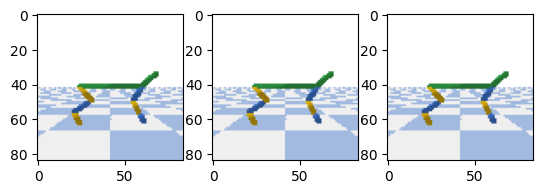

In [12]:
env = make_env()
obs = env.reset()
print(f"observation shape: {obs.shape}")

# 画像の描画
# 3チャネルごとにデータを取得する
f, ax = plt.subplots(1, 3)
ax = ax.flatten()

for i in range(0, 9, 3):
    img = obs[i : i + 3, :, :].transpose(1, 2, 0)
    img = Image.fromarray(img)
    ax[i // 3].imshow(img)

plt.show()

環境をリセットする場合は初期化された最初の画像が3つ重ねられるようになるため同じ画像が3つ並んでいるだけになります（FrameStackクラスのresetメソッド参照）．

次に行動を適当に与えることで異なる3枚の画像を出力してみます．  

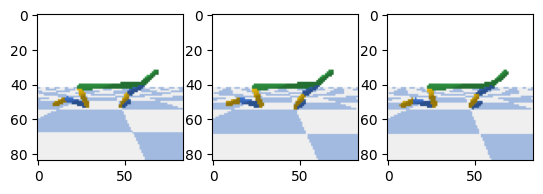

In [13]:
del env
env = make_env()
env.reset()

for _ in range(1000):
    # 適当な行動で次の観測を取得する
    (
        obs,
        _,
        _,
        _,
    ) = env.step(np.random.uniform(low=-1, high=1, size=6).astype(np.float32))

f, ax = plt.subplots(1, 3)
ax = ax.flatten()

for i in range(0, 9, 3):
    img = obs[i : i + 3, :, :].transpose(1, 2, 0)
    img = Image.fromarray(img)
    ax[i // 3].imshow(img)

plt.show()

ランダムな行動を取らせているため，少しおかしい画像が並ぶこともありますが，異なる画像3枚が並んでいることがわかると思います．

環境の実装についてはここまでです．次から本題であるTD-MPCの実装を進めていきます．  

## 3. 各モデルの実装  
TD-MPCで用いるモデルは，Task Oriented Latent Dynamics(TOLD)と呼びます．
まずはTOLDの概要と構成要素をおさらいします．  

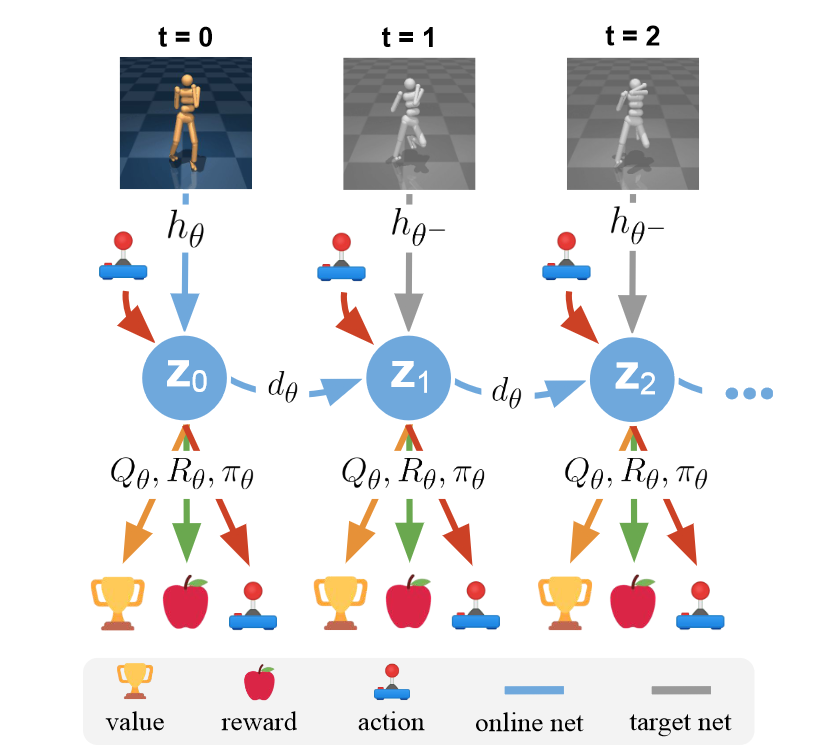

- Repreesntation model $\boldsymbol{z}_t = h_{\theta}(\boldsymbol{s}_t)$ : 観測画像を低次元の表現に埋め込むモデル．  
- Latent Dynamics$\boldsymbol{z}_{t+1} = d_{\theta}(\boldsymbol{z}_t, \boldsymbol{a}_t)$ : 低次元の表現上でのダイナミクスを学習するモデル．  
- Reward $\hat{r}_t = R_{\theta}(\boldsymbol{z}_t, \boldsymbol{a}_t)$ : 低次元の表現と行動から報酬を予測するモデル．  
- Value(Q function) $\hat{q}_t = Q_{\theta}(\boldsymbol{z}_t, \boldsymbol{a}_t)$ : 低次元の表現と行動から行動価値関数を予測するモデル．  
- Policy $\boldsymbol{a}_t \sim \pi_{\theta}(\boldsymbol{z}_t)$ : 低次元の表現から最適な行動を予測するパラメトリック方策．  

式中$\boldsymbol{s}_t$は時刻tの観測を表しており，図中の$\theta^-$はtarget modelであることを表しています．

まずはこれらのモデルをそれぞれ実装していきます．  

Representation modelは観測画像を低次元の表現に埋め込むためのモデルです．入力として観測画像を受け取り，CNNと全結合層を用いて低次元のベクトル表現に埋め込みます．

In [14]:
class Encoder(nn.Module):
    """Representation model"""
    def __init__(self, input_channels: int, num_channels: int, latent_dim: int, frame_stack: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        input_channels : int
            入力画像のチャネル数（frame stackする前の1枚のチャネル数）．
        num_channels : int
            隠れ層のチャネル数．
        latent_dim : int
            潜在表現の次元数．
        frame_stack : int
            frame stackによって重ねられる画像の枚数．
        """
        super().__init__()

        self._C = input_channels * frame_stack  # 入力データのチャネル数

        self.conv1 = nn.Conv2d(self._C, num_channels, kernel_size=7, stride=2)       #      (_C, 84, 84)      -> (num_channels, 39, 39)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=5, stride=2)  # (num_channels, 39, 39) -> (num_channels, 18, 18)
        self.conv3 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=2)  # (num_chanenls, 18, 18) -> (num_channels, 8, 8)
        self.conv4 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=2)  # (num_channels, 8, 8)   -> (num_channels, 3, 3)

        self.fc = nn.Linear(3 * 3 * num_channels, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor (batch size, C, H, w)
            入力となる観測画像．

        Returns
        -------
        z : torch.Tensor (batch size, latent dim)
            観測画像を低次元に埋め込んだ表現．
        """
        x = x / 255.  # [0-1]正規化
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # (B, num_channels x 3 x 3)
        z = self.fc(x)

        return z

Latent Dynamicsは低次元の表現に埋め込んだ観測と行動を入力として受け取り，次の観測（低次元の表現）を予測するモデルです．ただし，第8回で扱ったDreamerとは異なりRNNや確率的なモデルを利用せずに，決定論的なMLPのみを利用しています．  

In [15]:
class Dynamics(nn.Module):
    """Latent Dynamics"""
    def __init__(self, latent_dim: int, action_dim: int, hidden_dim: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        latent_dim : int
            潜在表現の次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            隠れ層の次元数．
        """
        super().__init__()

        self.fc1 = nn.Linear(latent_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor (batch size, latent dim + action dim)
            観測画像を低次元に埋め込んだ表現と行動を結合したテンソル．

        Returns
        -------
        z : torch.Tensor (batch size, latent dim)
            次時刻の観測画像の潜在表現の予測．
        """
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        z = self.fc3(x)

        return z

Reward modelとValue modelでは低次元の表現に埋め込んだ観測と行動を入力として受け取り，それぞれ即時報酬と行動価値関数を予測します．  

In [16]:
class Reward(nn.Module):
    """Reward model"""
    def __init__(self, latent_dim: int, action_dim: int, hidden_dim: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        latent_dim : int
            潜在表現の次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            隠れ層の次元数．
        """
        super().__init__()

        self.fc1 = nn.Linear(latent_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor (batch size, latent dim + action dim)
            観測画像を低次元に埋め込んだ表現と行動を結合したテンソル．

        Returns
        -------
        r : torch.Tensor (batch size, 1)
            報酬の予測値．
        """
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        r = self.fc3(x)

        return r

In [17]:
class QFunction(nn.Module):
    """Value model"""
    def __init__(self, latent_dim: int, action_dim: int, hidden_dim: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        latent_dim : int
            潜在表現の次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            隠れ層の次元数．
        """
        super().__init__()

        self.fc1 = nn.Linear(latent_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

        self.ln = nn.LayerNorm(hidden_dim) # これを消すとどうなる？

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor (batch size, latent dim + action dim)
            観測画像を低次元に埋め込んだ表現と行動を結合したテンソル．

        Returns
        -------
        r : torch.Tensor (batch size, 1)
            行動価値関数の予測値．
        """
        x = F.tanh(self.ln(self.fc1(x)))
        x = F.elu(self.fc2(x))
        q = self.fc3(x)

        return q

Policyは低次元の表現に埋め込んだ観測を入力として受け取り，最適な行動を予測します．PolicyクラスではMLPからの出力をそのまま返していますが，後半で実装するTOLDクラスの中の出力を平均するガウス分布から行動をサンプリングします．

In [19]:
class Policy(nn.Module):
    """Policy"""
    def __init__(self, latent_dim: int, action_dim: int, hidden_dim: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        latent_dim : int
            潜在表現の次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            隠れ層の次元数．
        """
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor (batch size, latent dim)
            観測画像を低次元に埋め込んだ表現．

        Returns
        -------
        a : torch.Tensor (batch size, action dim)
            各行動次元の行動（連続値の行動を想定している）．
        """
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        a = self.fc3(x)

        return a # 行動の平均値を返す

## 4. 補助機能の実装  
ここまででTOLDを構成するすべてのモデルの実装が終わりました．TOLDの実装に進む前に，いくつかの補助機能を先に実装しておきます．

### 4.1 Truncated Normal
Truncated Normalは取りうる値の区間が制限されているガウス分布のことであり，行動のサンプリングに利用します．今回扱う環境では行動は[-1, 1]の区間である必要があるため，[-1, 1]から値をサンプリングするようなガウス分布を実装しています．  

In [20]:
class TruncatedNormal(td.Normal):
    def __init__(self, loc: torch.Tensor, scale: torch.Tensor, low: float = -1.0, high: float = 1.0, eps: float = 1e-6) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        loc : torch.Tensor (batch size, action dim)
            各行動の平均．
        scale : torch.Tensor (batch size, action dim)
            各行動の標準偏差．
        low : float
            行動の最小値．
        high : float
            行動の最大値．
        eps : float
            [low, high]の区間に正規化するための微小な修正値．
        """
        super().__init__(loc, scale, validate_args=False)
        self.low = low
        self.high = high
        self.eps = eps

    def _clamp(self, x: torch.Tensor) -> torch.Tensor:
        """
        値を一定の区間に正規化するためのメソッド．

        Parameters
        ---------
        x : torch.Tensor (batch size, action dim)
            正規化前の値．

        Returns
        -------
        x : torch.Tensor(batch size, action dim)
            正規化後の値．
            [low, high]の区間に正規化されている．
        """
        clamped_x = torch.clamp(x, self.low + self.eps, self.high - self.eps)
        x = x - x.detach() + clamped_x.detach()  # 正規化処理は勾配が通らないため，xの勾配情報を与えておく
        return x

    def sample(self, clip: float | None = None, sample_shape: torch.Size = torch.Size()) -> torch.Tensor:
        """
        TruncatedNormalからサンプリングするためのメソッド．

        Parameters
        ----------
        clip : float
            サンプリングする際の標準偏差によるばらつきの上限．
        sample_shape : torch.Size
            継承元であるNormalで設定されている引数．パラメータのshapeを格納するために利用される．

        Returns
        -------
        x : torch.Tensor (batch size, action dim)
            TruncatedNormalからサンプリングされた行動．
        """
        shape = self._extended_shape(sample_shape)  # mu, stdの形状を取得
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)   # ノイズ（標準偏差）

        eps *= self.scale
        if clip is not None:
            eps = torch.clamp(eps, -clip, clip)  # ノイズの大きさに制限をかける
        x = self.loc + eps
        return self._clamp(x)

### 4.2 Replay Buffer  
次に学習に利用するデータを保持・サンプリングしておくためのリプレイバッファを実装します．  
今回利用するリプレイバッファでは，連続している観測をサンプリングする機能と，Frame Stackに合わせて複数枚の観測を重ねてサンプリングする機能が実装されています．  

またこれまでのリプレイバッファとは異なり，prioritized experience replay[[2]](#scrollTo=9bd90a42-72ab-4442-9f94-37d3f612d4cc)を用いています．これはモデルが予測が困難だった（=予測結果が真の値と大きくずれいてる）データが優先的にサンプリングされることで学習効率を向上させています．この優先度はTD targetとvalue modelのずれが大きいほど大きくなるようになっています．  

In [21]:
class ReplayBuffer:
    """リプレイバッファ"""
    def __init__(self, cfg: Config) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        cfg : Config
            設定に必要な値をまとめたコンフィグ．
        """
        self.cfg = cfg
        self.device = "cpu"  # バッファにためておくときはメモリを使用
        self.capacity = min(cfg.train_steps, cfg.max_buffer_size)  # バッファのサイズ
        dtype = torch.uint8
        obs_shape = (3, *cfg.obs_shape[-2:])  # 1枚の観測の形状
        self._obs = torch.empty((self.capacity+1, *obs_shape), dtype=dtype, device=self.device)
        self._last_obs = torch.empty((self.capacity // cfg.episode_length, *cfg.obs_shape), dtype=dtype, device=self.device)
        self._action = torch.empty((self.capacity, cfg.action_dim), dtype=torch.float32, device=self.device)
        self._reward = torch.empty((self.capacity, ), dtype=torch.float32, device=self.device)
        self._priorities = torch.ones((self.capacity, ), dtype=torch.float32, device=self.device)
        self._eps = 1e-6
        self._full = False
        self.idx = 0

    def add(self, episode: dict) -> None:
        """
        エピソードをバッファに格納するためのメソッド．

        Parameters
        ----------
        episode : dict
            1エピソード分の観測，行動，報酬をまとめた辞書．
        """
        self._obs[self.idx:self.idx+self.cfg.episode_length] = episode["obs"][:-1, -3:]
        self._last_obs[self.idx//self.cfg.episode_length] = episode["obs"][-1]
        self._action[self.idx:self.idx+self.cfg.episode_length] = episode["action"]
        self._reward[self.idx:self.idx+self.cfg.episode_length] = episode["reward"]
        if self._full:
            max_priority = self._priorities.max().to(self.device).item()
        else:
            max_priority = 1. if self.idx == 0 else self._priorities[:self.idx].max().to(self.device).item()

        # 新しく追加されるデータは，優先度を最大にする
        # ただしエピソードを跨がないように優先度を0にしておく
        mask = torch.arange(self.cfg.episode_length) >= self.cfg.episode_length-self.cfg.horizon
        new_priorities = torch.full((self.cfg.episode_length, ), max_priority, device=self.device)
        new_priorities[mask] = 0
        self._priorities[self.idx:self.idx+self.cfg.episode_length] = new_priorities
        self.idx = (self.idx + self.cfg.episode_length) % self.capacity
        self._full = self._full or self.idx == 0

    def update_priorities(self, idxs: torch.Tensor, priorities: torch.Tensor) -> None:
        """
        データをサンプリングする際の優先度を更新するためのメソッド．

        Parameters
        ----------
        idxs : torch.Tensor (batch size, )
            サンプリングの際に利用したインデックス．
        priorities : torch.Tensor (batch size, )
            モデルの推論から計算される優先度．
        """
        self._priorities[idxs] = priorities.squeeze(1).to(self.device) + self._eps

    def _get_obs(self, arr: torch.Tensor, idxs: torch.Tensor) -> torch.Tensor:
        """
        インデックスから連続した3枚の画像を得るためのメソッド．

        Parameters
        ----------
        arr : torch.Tensor (batch size, 3, H, W)
            リプレイバッファの観測画像をまとめたテンソル．
        idxs : torch.Tensor (batch size, )
            サンプリングに利用するインデックスのテンソル．

        Returns
        -------
        obs : torch.Tensor (batch size, 9, H, W)
            idx-2, idx-1, idxの3枚の画像を重ねた画像．
        """
        # idxの画像を取得
        obs = torch.empty((self.cfg.batch_size, 3*self.cfg.frame_stack, *arr.shape[-2:]), dtype=arr.dtype, device="cuda")
        obs[:, -3:] = arr[idxs].cuda()
        _idxs = idxs.clone()
        mask = torch.ones_like(_idxs, dtype=torch.bool)

        # frame stackのため，idxより前の画像を取得して重ねる
        # idxがエピソードを跨ぐ場合は，跨がないように同じ画像を重ねる
        for i in range(1, self.cfg.frame_stack):
            mask[_idxs % self.cfg.episode_length == 0] = False
            _idxs[mask] -= 1
            obs[:, -(i+1)*3:-i*3] = arr[_idxs].cuda()
        return obs.float()

    def sample(self) -> Tuple[torch.Tensor]:
        """
        バッファからランダムに経験をサンプリングするためのメソッド．

        Returns
        -------
        obs : torch.Tensor (batch size, 9, H, W)
            frame stackの分だけ重ねた画像．
        next_obs : torch.Tensor (horizon + 1, batch size, 3, H, W)
            obsの次の時刻以降の画像．
        action : torch.Tensor (horizon + 1, batch size, action dim)
            サンプリングされた行動．
        reward : torch.Tensor (horizon + 1, batch size, )
            サンプリングされた報酬．
        idxs : torch.Tensor (batch size, )
            サンプリングに利用したインデックス．
        weights : torch.Tensor (batch size, )
            損失に重みづけするためのテンソル．
        """
        # 優先度による各idxが選択される確率
        # 優先度は予測がうまくいかないものほど高くなる
        probs = (self._priorities if self._full else self._priorities[:self.idx]) ** self.cfg.per_alpha
        probs /= probs.sum()
        total = len(probs)

        # データ数が最大になったら重複なしでサンプリング（replaceの部分）
        idxs = torch.from_numpy(np.random.choice(total, self.cfg.batch_size, p=probs.cpu().numpy(), replace=not self._full)).to(self.device)

        # 優先度に応じて損失に重みづけする
        weights = (total * probs[idxs]) ** (-self.cfg.per_beta)
        weights /= weights.max()

        obs = self._get_obs(self._obs, idxs)
        next_obs_shape = (3 * self.cfg.frame_stack, *self._last_obs.shape[-2:])
        next_obs = torch.empty((self.cfg.horizon+1, self.cfg.batch_size, *next_obs_shape), dtype=obs.dtype, device=obs.device)
        action = torch.empty((self.cfg.horizon+1, self.cfg.batch_size, *self._action.shape[1:]), dtype=torch.float32, device=self.device)
        reward = torch.empty((self.cfg.horizon+1, self.cfg.batch_size), dtype=torch.float32, device=self.device)

        # horizonの長さだけデータを取得
        for t in range(self.cfg.horizon+1):
            _idxs = idxs + t
            next_obs[t] = self._get_obs(self._obs, _idxs+1)
            action[t] = self._action[_idxs]
            reward[t] = self._reward[_idxs]

        # データをGPUに移動
        if not action.is_cuda:
            action, reward, idxs, weights = action.cuda(), reward.cuda(), idxs.cuda(), weights.cuda()

        return obs, next_obs, action, reward.unsqueeze(2), idxs, weights

### 4.3 linear schedule  
TD-MPCでは行動をサンプリングする際の標準偏差の値と，プランニングに利用する系列長をlinear schedulerで調整しています．標準偏差の値は学習が進むにつれて小さく，系列長は徐々に大きくしています．このために利用するスケジューラをlinear_scheduleとして実装しています．  

In [22]:
def linear_schedule(start: float, end: float, duration: int, step: int) -> float:
    """
    std / horizonを線形に減少 / 増加させるためのスケジューラ．

    Parameters
    ---------
    start : float
        スケジューリングする際の初期値．
    end : float
        スケジューリングする際の終端値．
    duration : int
        startからendまでにかかるstep数．
    step : int
        現在のstep数．

    Returns
    -------
    result : float
        stepに合わせて減衰させた値．
    """
    mix = np.clip(step / duration, 0.0, 1.0)
    return (1.0 - mix) * start + mix * end

### 4.4 Random Shift Augmentation  
観測画像をそのまま入力するのではなく，汎化性を持たせるためにデータ拡張を行っています．TD-MPCではランダムに4ピクセルずらすような処理を入力前にしています[[3]](#scrollTo=9bd90a42-72ab-4442-9f94-37d3f612d4cc)．

In [23]:
# 結局データ拡張するならDrMとか参考にしても良いかも．

class RandomShiftAug(nn.Module):
    """画像をランダムに±4ピクセルランダムにずらすデータ拡張．"""
    def __init__(self, img_size: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        img_size : int
            入力画像のサイズ．
        """
        super().__init__()
        self.pad = int(img_size / 21)  # パディングサイズ

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor (batch size, C, H, W)
            入力画像．

        Returns
        -------
        result : torch.Tensor (batch size, C, H, W)
            入力画像をランダムにずらした画像．
        """
        n, c, h, w = x.size()
        padding = tuple([self.pad] * 4)
        x = F.pad(x, padding, "replicate")
        eps = 1.0 / (h + 2 * self.pad)
        arange = torch.linspace(-1.0 + eps, 1.0 - eps, h + 2 * self.pad, device=x.device, dtype=x.dtype)[:h]
        arange = arange.unsqueeze(0).repeat(h, 1).unsqueeze(2)
        base_grid = torch.cat([arange, arange.transpose(1, 0)], dim=2)
        base_grid = base_grid.unsqueeze(0).repeat(n, 1, 1, 1)
        shift = torch.randint(0, 2 * self.pad + 1, size=(n, 1, 1, 2), device=x.device, dtype=x.dtype)
        shift *= 2.0 / (h + 2 * self.pad)
        grid = base_grid + shift
        return F.grid_sample(x, grid, padding_mode='zeros', align_corners=False)

最後にTDターゲットを計算するために利用する関数を実装しています．  
復習になりますが，TDターゲットは以下の式で計算されます．行動価値関数の計算にはtarget modelを利用することに注意してください．  

$$\delta^{TD} = r_i + \gamma Q_{\theta^-}(\boldsymbol{z}_{i+1}, \pi_{\theta}(\boldsymbol{z}_{i+1}))$$

In [24]:
def calc_td_target(cfg: Config, model: torch.nn.Module, model_target: torch.nn.Module, next_obs: torch.Tensor, reward: torch.Tensor) -> torch.Tensor:
    """
    Q関数を学習する際に利用するTDターゲットを計算するための関数．

    Parameters
    ----------
    cfg : Config
        計算に必要な値を格納したコンフィグ．
    model : torch.nn.Module
        Q関数や方策をまとめてあるモデル．
    model_target : torch.nn.Module
        ターゲットQネットワークを保持しているtarget model．
    next_obs : torch.Tensor (batch size, C, H, W)
        次時刻の行動価値関数を計算するために利用する観測画像．
    reward : torch.Tensor (batch size, )
        報酬の値．

    Returns
    -------
    td_target : torch.Tensor (batch size, )
        TDターゲットの計算結果．
    """
    next_z = model.h(next_obs)
    td_target = reward + cfg.discount * torch.min(*model_target.Q(next_z, model.pi(next_z, cfg.min_std)))
    return td_target

## 5. TD-MPCの実装  
ここからTD-MPCの実装に入っていきます．流れとしてはまず上記で実装した各モデルをまとめてTOLDクラスを実装し，実際にプランニングを行うTD-MPCクラスを実装していきます．  

### 5.1 TOLD
まずはTOLDクラスを実装します．このクラスは各モデルをまとめ，メソッドとして観測の埋め込みやダイナミクスを実装したものになります．  
元実装に合わせて直行行列でのパラメータの初期化，reward modelとvalue modelの最終層をゼロで初期化する処理を入れています．これにより学習初期のバイアスを抑制する効果があります．  

またTOLDクラスはQ関数を2つ持っています．これはTD3[[4]](#scrollTo=9bd90a42-72ab-4442-9f94-37d3f612d4cc)で提案された推定誤差やノイズによってQ関数が過大評価されるという問題を抑制するための手法です(Clipped Double Q-learning)．学習の際には2つのQ関数両方で予測を行い値の小さいものを用いてTDターゲットや収益の計算を行います．  

In [25]:
def orthogonal_init(m: nn.Module) -> None:
	"""パラメータを直行行列で初期化．"""
	if isinstance(m, nn.Linear):
		nn.init.orthogonal_(m.weight.data)
		if m.bias is not None:
			nn.init.zeros_(m.bias)
	elif isinstance(m, nn.Conv2d):
		gain = nn.init.calculate_gain('relu')
		nn.init.orthogonal_(m.weight.data, gain)
		if m.bias is not None:
			nn.init.zeros_(m.bias)

In [26]:
class TOLD(nn.Module):
    """Task Oriented Latent Dynamics(TOLD)"""
    def __init__(
        self,
        latent_dim: int,
        action_dim: int,
        hidden_dim: int,
        input_channels: int,
        num_channels: int,
        frame_stack: int
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        latent_dim : int
            観測画像を埋め込んだ表現の次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            各モデルの隠れ層の次元数．
        input_channels : int
            representation modelに入力する画像のチャネル数．
        num_channels : int
            representation modelの隠れ層のチャネル数．
        frame_stack : int
            frame stackで重ねる画像の枚数．
        """
        super().__init__()
        self._encoder = Encoder(input_channels, num_channels, latent_dim, frame_stack)  # representation model
        self._dynamics = Dynamics(latent_dim, action_dim, hidden_dim)  # latent dynamics
        self._reward = Reward(latent_dim, action_dim, hidden_dim)  # reward modle
        self._pi = Policy(latent_dim, action_dim, hidden_dim)  # policy
        self._Q1, self._Q2 = QFunction(latent_dim, action_dim, hidden_dim), QFunction(latent_dim, action_dim, hidden_dim)  # value model

        # 直行行列での初期化と，reward mdoelとQ networkの最後の層のパラメータ・バイアスをゼロに初期化
        # 学習初期のバイアスを抑制する働きがある
        self.apply(orthogonal_init)
        for m in [self._reward, self._Q1, self._Q2]:
            m.fc3.weight.data.fill_(0)
            m.fc3.bias.data.fill_(0)

    def h(self, obs: torch.Tensor) -> torch.Tensor:
        """
        観測画像をエンコーダを用いて低次元の表現に埋め込む．

        Parameters
        ----------
        obs : torch.Tensor (batch size, C, H, W)
            入力となる観測画像．

        Returns
        -------
        z : torch.Tensor (batch size, latend dim)
            観測画像を低次元の空間に埋め込んだ表現．
        """
        return self._encoder(obs)

    def next(self, z: torch.Tensor, a: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        状態の低次元の表現と行動から，次の低次元の表現と報酬を予測する．

        Parameters
        ----------
        z : torch.Tensor (batch size, latent dim)
            観測画像を低次元空間に埋め込んだ表現．
        a : torch.Tensor (batch size, action dim)
            行動．

        Returns
        -------
        z : torch.Tensor (batch size, latent dim)
            次の時刻の低次元空間の表現の予測値．
        r : torch.Tensor (batch size, )
            入力された表現，行動に対する報酬の予測値．
        """
        x = torch.cat([z, a], dim=-1)
        return self._dynamics(x), self._reward(x)

    def pi(self, z: torch.Tensor, std=0) -> torch.Tensor:
        """
        Policyネットワークを利用して行動をサンプリングする．

        Parameters
        ----------
        z : torch.Tensor (batch size, latent dim)
            観測画像を低次元空間に埋め込んだ表現．

        Returns
        -------
        a : torch.Tensor (batch size, action dim)
            入力された表現に対する行動の予測値．
        """
        mu = torch.tanh(self._pi(z))
        if std > 0:
            std = torch.ones_like(mu) * std
            return TruncatedNormal(mu, std).sample(clip=0.3)
        return mu

    def Q(self, z: torch.Tensor, a: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        Qネットワークを利用して行動価値関数を予測する．
        実装ではQネットワークによる価値関数の過大評価を防ぐために，2つのQ関数を利用する．

        Parameters
        ----------
        z : torch.Tensor (batch size, latent dim)
            観測画像を低次元空間に埋め込んだ表現．
        a : torch.Tensor (batch size, action dim)
            行動．

        Returns
        -------
        Q1 : torch.Tensor (batch size, )
            1つ目のQネットワークのよる行動価値関数の予測値．
        Q2 : torch.Tensor (batch size, )
            2つ目のQネットワークによる行動価値関数の予測値．
        """
        x = torch.cat([z, a], dim=-1)
        return self._Q1(x), self._Q2(x)

### 5.2 TD-MPC
次に実際にプランニングを行うエージェントとしてTDMPCクラスを実装します．まずはTD-MPCの概要を見ておきましょう．

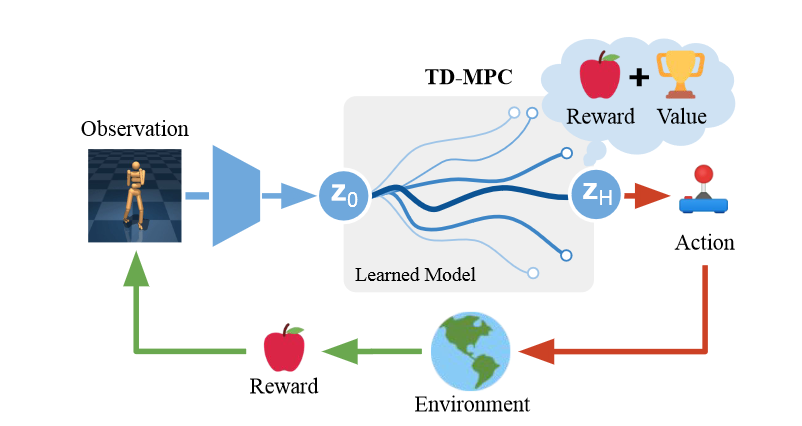

画像のプランニング部分（TD-MPCの文字の下の灰色背景部分）を見ると，$z_0$から$z_H$までで複数の想像上の軌道を作成しています．先に実装したTOLDはこの部分で使用しますが，TOLDはあくまでプランニングを行うための補助的な機能であり，実際のプランニングでの行動選択に直接用いることはしません．

想像上の軌道の生成にはTOLDでの生成に加え，多次元ガウス分布を利用します．TOLDの要素であるPolicyは行動価値関数を最大にするように学習するため，長期的な報酬を最大にするための方策となります．これとは別に$z_0$から$z_H$までの長さHの軌道での局所的な報酬を最大にするための方策としてガウス分布を学習します．  

以上を踏まえてまずはTD-MPCのプランニングの流れを示します．

1. ガウス分布のパラメータを初期化します．$\mu^0, \sigma^0$と表し，添え字は更新回数を示しています．
2. $z_0$を初期状態として，長さHの想像上の軌道の行動をTOLDを用いて$N_{\pi}$個サンプリングします．
3. 同様に長さHの想像上の軌道の行動を多次元ガウス分布$\mathcal{N}(\mu^{j-1}, (\sigma^{j-1})^2 \mathbf{I})$を用いて$N$個します．
4. サンプリングされた軌道の収益をTOLDを用いて計算します．初期状態と各時刻の行動と，TOLDのlatent dynamics / reward modelを利用することで収益を推定します(estimate_valueメソッド)．
5. 計算された収益の中で上位k個の軌道を用いてパラメータを更新して$\mu^j, \sigma^j$を得ます．
6. 手順2-5を$J$回繰り返して得られたパラメータによって$z_0$に対する行動をサンプリングする．

手順4のある軌道$\Gamma$に対する収益の推定は以下の式で行われ，これはestimate_valueメソッドで定義されています．

$$\phi_{\Gamma} \triangleq  \mathbb{E}_{\Gamma} [\gamma^H Q_{\theta}(\boldsymbol{z}_H, \boldsymbol{a}_H) + \sum^{H-1}_{t=0} \gamma^t R_{\theta}(\boldsymbol{z}_t, \boldsymbol{a}_t)]$$

上記の推定値を用いてスコア$\Omega$を計算し，手順5でのパラメータ更新を以下の式で行います．

$$\Omega_i = e^{\tau(\phi_{\Gamma,i})}$$

$$\mu^j = \frac{\sum^k_{i=1} \Omega_i \Gamma_i}{\sum^k_{i=1} \Omega_i}, \; \sigma^j = \sqrt{\frac{\sum^k_{i=1}\Omega_i(\Gamma_i - \mu^j)^2}{\sum^k_{i=1}\Omega_i}}$$

これでTD-MPCを実装する準備ができたので，実際に実装しましょう．

In [28]:
class TDMPC:
    def __init__(self, cfg: Config) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        cfg : Config
            設定に利用する値を格納したコンフィグ．
        """
        self.cfg = cfg
        self.device = "cuda"
        self.std = linear_schedule(cfg.max_std, cfg.min_std, cfg.duration, 0)  # 行動分布の標準偏差の最小値
        self.model = TOLD(
            cfg.latent_dim,
            cfg.action_dim,
            cfg.hidden_dim,
            cfg.input_channels,
            cfg.num_channels,
            cfg.frame_stack,
        ).cuda()
        self.model_target = deepcopy(self.model)
        self.model.eval()
        self.model_target.eval()

    def state_dict(self) -> Dict[str, OrderedDict]:
        """学習したモデルのパラメータを取得するメソッド．"""
        return {"model": self.model.state_dict(), "model_target": self.model_target.state_dict()}

    def save(self, f: str) -> None:
        """
        学習したモデルのパラメータを保存するメソッド．

        Parameters
        ----------
        f : str
            パラメータの保存先のパス．
        """
        torch.save(self.state_dict(), f)

    def load(self, f: str) -> None:
        """
        学習したモデルのパラメータを読み込むメソッド．

        Parameters
        ----------
        f : str
            パラメータの保存先のパス．
        """
        d = torch.load(f)
        self.model.load_state_dict(d["model"])
        self.model_target.load_state_dict(d["model_target"])

    @torch.no_grad()
    def estimate_value(self, z: torch.Tensor, actions: torch.Tensor, horizon: int) -> torch.Tensor:
        """
        得られた表現と行動から価値を推定するための関数．

        Parameters
        ----------
        z : torch.Tensor (batch size, latent dim)
            観測画像を低次元の空間に埋め込んだ表現．
        action : torch.Tensor (horizon, batch size, action dim)
            行動系列．
        horizon : int
            系列長．

        Returns
        -------
        G : torch.Tensor (batch size, )
            各バッチの価値の予測値．
        """
        G, discount = 0, 1
        for t in range(horizon):
            z, reward = self.model.next(z, actions[t])  # latent dynamicsで次の表現と得られる報酬を予測
            G += discount * reward  # 収益に加算
            discount *= self.cfg.discount
        G += discount * torch.min(*self.model.Q(z, self.model.pi(z, self.cfg.min_std)))
        return G

    @torch.no_grad()
    def plan(self, obs: np.ndarray, z: torch.Tensor | None = None, eval_mode: bool = False, step: int | None = None, t0: bool = True) -> torch.Tensor:
        """
        観測画像からプランニングするためのメソッド．

        Parameters
        ----------
        obs : np.ndarray
            観測画像．
        z : torch.Tensor (1, latent dim) | None
            観測画像を低次元空間に埋め込んだ表現．open loopでの推論時にのみ利用する．
        eval_model : bool
            評価時の処理にするかどうかを決めるフラグ．
            評価時は行動選択時にノイズを加算しないようにする．
        step : int
            学習のstep数．horizon長のスケジューリングに使用する．
        t0 : bool
            入力された観測画像が環境の初期値かどうかを示すフラグ．

        Returns
        -------
        a : torch.Tensor (1, action dim)
            プランニングによって選択された行動．
        """
        # 観測画像が得られている場合
        if z is None:
            obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
            horizon = int(min(self.cfg.horizon, linear_schedule(1, 5, 25000, step)))
            num_pi_trajs = int(self.cfg.mixture_coef * self.cfg.num_samples)  # N_{\pi}

            # 1. パラメータの初期化
            mean = torch.zeros(horizon, self.cfg.action_dim, device=self.device)  # \mu^0
            std = 2 * torch.ones(horizon, self.cfg.action_dim, device=self.device)  # \sigma^0

            # 2. 学習したダイナミクスと方策で軌道を生成する
            if num_pi_trajs > 0:
                pi_actions = torch.empty(horizon, num_pi_trajs, self.cfg.action_dim, device=self.device)
                z = self.model.h(obs).repeat(num_pi_trajs, 1)
                for t in range(horizon):
                    pi_actions[t] = self.model.pi(z, self.cfg.min_std)
                    z, _ = self.model.next(z, pi_actions[t])

            # 価値推定に利用するため，初期状態をベクトル表現に埋め込む
            z = self.model.h(obs).repeat(self.cfg.num_samples+num_pi_trajs, 1)

        # open loopでの推定の場合
        else:
            horizon = int(min(self.cfg.horizon, linear_schedule(1, 5, 25000, step)))
            num_pi_trajs = int(self.cfg.mixture_coef * self.cfg.num_samples)  # N_{\pi}

            # 1. パラメータの初期化
            mean = torch.zeros(horizon, self.cfg.action_dim, device=self.device)  # \mu^0
            std = 2 * torch.ones(horizon, self.cfg.action_dim, device=self.device)  # \sigma^0

            # 2. 学習したダイナミクスと方策で軌道を生成する
            if num_pi_trajs > 0:
                pi_actions = torch.empty(horizon, num_pi_trajs, self.cfg.action_dim, device=self.device)
                tz = z.repeat(num_pi_trajs, 1)
                for t in range(horizon):
                    pi_actions[t] = self.model.pi(tz, self.cfg.min_std)
                    tz, _ = self.model.next(tz, pi_actions[t])

            # 価値推定に利用するため，初期状態をベクトル表現に埋め込む
            z = z.repeat(self.cfg.num_samples+num_pi_trajs, 1)

        # 次のプランニングでは，1ステップ前に利用した平均を再利用する
        if not t0 and hasattr(self, "_prev_mean"):
            mean[:-1] = self._prev_mean[1:]

        for i in range(self.cfg.iterations):
            # 3. ガウス分布から行動を生成
            actions = torch.randn(horizon, self.cfg.num_samples, self.cfg.action_dim, device=std.device)
            actions = torch.clamp(mean.unsqueeze(1) + std.unsqueeze(1) * actions, -1, 1)
            if num_pi_trajs > 0:
                actions = torch.cat([actions, pi_actions], dim=1)  # (horizon, num_pi_trajs + cfg.num_samples, action dim)

            # 4. 各行動に対する価値の推定
            value = self.estimate_value(z, actions, horizon).nan_to_num_(0)  # (num_pi_trajs+ cfg.num_samples, 1)

            # 5. 価値が高かった行動を抽出して価値を推定
            elite_idxs = torch.topk(value.squeeze(1), self.cfg.num_elites, dim=0).indices
            elite_value, elite_actions = value[elite_idxs], actions[:, elite_idxs]  # (cfg.num_elits, 1), (horizon, cfg.num_elites, action dim)

            # 6. 平均と標準偏差を更新
            max_value = elite_value.max(0)[0]
            score = torch.exp(self.cfg.temperature * (elite_value - max_value))  # オーバーフロー対策のため最大値を引く (cfg.num_elites, 1)
            score /= (score.sum(0) + 1e-9)  # [0-1]に正規化する（ゼロ除算を防ぐ）
            _mean = torch.sum(score.unsqueeze(0) * elite_actions, dim=1) / (score.sum(0) + 1e-9) # WRITE ME
            _std =  torch.sqrt(torch.sum(score.unsqueeze(0) * (elite_actions - _mean.unsqueeze(1)) ** 2, dim=1) / (score.sum(0) + 1e-9)) # WRITE ME
            _std = _std.clamp(self.std, 2)

            mean, std = self.cfg.momentum * mean + (1 - self.cfg.momentum) * _mean, _std

        # 価値の推定値が高い軌道の行動ほど選ばれやすい
        score = score.squeeze(1).cpu().numpy()
        actions = elite_actions[:, np.random.choice(np.arange(score.shape[0]), p=score)]
        self._prev_mean = mean
        mean, std = actions[0], _std[0]
        a = mean

        # 探索時はノイズを加える
        if not eval_mode:
            a += std * torch.randn(self.cfg.action_dim, device=std.device)
        return a

    def plan_openloop(self, obs: np.ndarray, step: int, episode_length: int) -> (List[float], float):
        """
        初期状態の観測のみから1エピソード分の行動を推定するメソッド．

        Parameters
        ----------
        obs : np.ndarray
            観測画像．
        step : int
            学習のstep数．horizon長のスケジューリングに使用する．
        episode_length: int
            1エピソードのステップ数．

        Returns
        -------
        actions : List[float]
            1エピソード分の行動系列．
        estimate_rewards : float
            Reward modelでの推測される報酬の1エピソード分の総和．
        """

        actions = []
        estimate_rewards = 0
        t = 0

        # 観測を低次元表現に埋め込んでおく
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        z = self.model.h(obs)
        for _ in range(episode_length):
            a = self.plan(None, z, True, step, t0=(t==0))
            actions.append(a)
            t += 1

            a = a.unsqueeze(0)
            z, reward = self.model.next(z, a)

            estimate_rewards += reward

        return actions, estimate_rewards

最後に評価のために用いる関数を定義しておきます．  

In [29]:
def evaluate(agent: TDMPC, num_episodes: int, step: int) -> None:
    """
    学習したエージェントを評価するための関数．

    Parameters
    ----------
    agent : TDMPC
        学習したエージェントのインスタンス．
    num_episodes : int
        評価に利用するエピソードの数．
    step : int
        学習のstep数．
    """
    env = make_env()
    episode_rewards = []
    for i in range(num_episodes):
        obs, done, rewards, t = env.reset(), False, 0, 0  # 初期化
        while not done:
            action = agent.plan(obs, eval_mode=True, step=step, t0=(t==0))  # エージェントによるプランニング
            obs, reward, done, _ = env.step(action.cpu().numpy())
            rewards += reward
            t += 1
        episode_rewards.append(rewards)

    episode_rewards = np.array(episode_rewards)
    print(f"[Eval] step: {step} mex reward: {episode_rewards.max():.4f} mean reward {episode_rewards.mean():.4f}")

## 6. 学習
TOLDとTD-MPCの実装ができたので，ここからは実際に学習していきます．  
ただし実行には時間がかかるため，演習中では実行はしません．  

まずはランダムな行動をとってリプレイバッファに追加します．  

In [30]:
def reset_episode() -> Dict[str, torch.Tensor]:
    """
    episodeを格納する辞書を初期化するための関数．

    Returns
    -------
    episode : Dict[torch.Tensor]
        1エピソード分の観測，行動，報酬を格納するための辞書．
    """
    episode = {"obs": torch.empty((cfg.episode_length+1, *env.observation_space.shape), dtype=torch.uint8, device="cpu"),
               "action": torch.empty((cfg.episode_length, cfg.action_dim), dtype=torch.float32, device="cpu"),
               "reward": torch.empty((cfg.episode_length, ), dtype=torch.float32, device="cpu")
              }
    return episode

env = make_env()
cfg.action_dim = env.action_space.shape[0]
replay_buffer=  ReplayBuffer(cfg)

for _ in range(cfg.seed_episode):
    episode = reset_episode()
    obs = env.reset()
    done = False
    episode["obs"][0] = torch.from_numpy(obs)
    idx = 0

    # 1エピソード分観測，報酬，行動をためる
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        episode["obs"][idx+1] = torch.from_numpy(obs)
        episode["reward"][idx] = torch.tensor([reward])
        episode["action"][idx] = torch.from_numpy(action)
        idx += 1

    # 1エピソード分のデータをバッファに格納
    replay_buffer.add(episode)

実際に学習をしていきます．  
学習を行うのはTOLDの各構成要素になります．学習では時刻tからt+Hまでの軌道を用いて学習を行い，全体の損失は各時刻の損失の総和をとる形になります．  

$$\mathcal{J}(\theta; \Gamma) = \sum^{t+H}_{i=t} \rho^{i-t} \mathcal{L}(\theta;\Gamma_i)$$

各時刻の損失関数は，以下の構成要素のそれぞれの損失の重み付け和で表されます．

$$\mathcal{L}(\theta;\Gamma_i) = c_1 \mathcal{L}_{\text{reward}}(\theta;\Gamma_i) + c_2 \mathcal{L}_{\text{value}}(\theta;\Gamma_i) + c_3 \mathcal{L}_{\text{latent}}(\theta;\Gamma_i)$$

**Reward model**: 報酬の推定値と真の値を近づけるように学習します．  
$\mathcal{L}_{\text{reward}} = (R_{\theta}(\boldsymbol{z}_i, \boldsymbol{a}_i) - r_i)^2$  

**Value model**: 行動価値関数の推定値とTDターゲットを近づけるように学習します．  
$\mathcal{L}_{\text{value}} = (Q_{\theta}(\boldsymbol{z}_i, \boldsymbol{a}_i) - (r_i + \gamma Q_{\theta^-}(\boldsymbol{z}_{i+1}, \pi_{\theta}(\boldsymbol{z}_{i+1})))^2$

**Latent dynamics**: Latent dynamicsによる次の状態の推定値と，Representation mdoel(target)による真の観測のベクトル表現を近づけるように学習します．  
$\mathcal{L}_{\text{latent}} = (d_{\theta}(\boldsymbol{z}_i, \boldsymbol{a}_i) - h_{\theta^-}(\boldsymbol{s}_{i+1}))^2$

Representation modelは各モデルの入力に利用されるベクトル表現を埋め込むのに使われ，各推定を行うために必要な情報をベクトル表現が持つように学習されることが期待されます．  

またPolicyの損失関数はQ関数を最大にするように最適化されるため，損失関数はQ関数の符号を反転したものになります．  
**Policy**  
$\mathcal{J}_{\pi}(\theta;\Gamma) = -\sum^{t+H}_{i=t}\rho^{i-t} Q_{\theta}(\boldsymbol{z}_i, \pi_{\theta}(\text{sg}(\boldsymbol{z}_i)))$

学習時には，エージェントを用いて1エピソード分探索を行いリプレイバッファに経験を格納した後，一定イテレーションだけパラメータを更新します．  

In [31]:
# 環境，エージェントの初期化
env = make_env()
agent = TDMPC(cfg)
aug = RandomShiftAug(cfg.image_size)
model = agent.model
model_target = agent.model_target

# 各モデルのoptimizerの設定，データ拡張の設定
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
pi_optimizer = torch.optim.Adam(model._pi.parameters(), lr=cfg.lr)
aug = RandomShiftAug(cfg.image_size)

# 学習ループ
for step in range(0 + cfg.seed_episode * cfg.episode_length, cfg.train_steps + cfg.seed_episode * cfg.episode_length, cfg.episode_length):
    model.eval()
    model_target.eval()

    # エージェントを利用して経験をためる
    obs = env.reset()
    episode = reset_episode()
    done = False
    idx = 0
    t = 0
    total_reward = 0
    episode["obs"][t] = torch.from_numpy(obs)

    while not done:
        action = agent.plan(obs, step=step, t0=(t==0))
        obs, reward, done, _ = env.step(action.cpu().numpy())
        episode["obs"][t+1] = torch.from_numpy(obs)
        episode["reward"][t] = torch.tensor([reward])
        episode["action"][t] = action
        total_reward += reward
        t += 1

    replay_buffer.add(episode)


    # 学習
    # world model(representation / dynamics / reward)とvalue modelの更新
    update_iter = cfg.seed_episode * cfg.episode_length if step == (cfg.seed_episode * cfg.episode_length) else cfg.episode_length
    for i in range(update_iter):
        model.train()
        agent.std = linear_schedule(cfg.max_std, cfg.min_std, cfg.duration, step+i)  # policyの標準偏差の最小値を更新
        obs, next_obses, action, reward, idxs, weights = replay_buffer.sample()  # バッファからデータをサンプリング
        optimizer.zero_grad()

        # representation modelで観測をベクトル表現に埋め込み
        z = model.h(aug(obs))  # z_t
        zs = [z.detach()]

        latent_loss, reward_loss, value_loss, priority_loss = 0, 0, 0, 0

        # 想像上の軌道を生成して各値を推定する
        for t in range(cfg.horizon):
            Q1, Q2 = model.Q(z, action[t])  # Q(z_t, a_t)
            z, reward_pred = model.next(z, action[t])  # z_{t+1} = d(z_t, a_t)
            with torch.no_grad():
                next_obs = aug(next_obses[t])
                next_z = model_target.h(next_obs)  # z_{t+1} = h(s_{t+1})
                td_target = calc_td_target(cfg, model, model_target, next_obs, reward[t])  # r_i + Q(z_{t+1}, pi(z_{t+1})
            zs.append(z.detach())  # policyの更新用にzの勾配を切って保存

            # 損失関数の計算（F.mse_lossを利用する）
            rho = cfg.rho ** t
            reward_loss += rho * F.mse_loss(reward_pred, reward[t], reduction="none") # WRITE ME #L_{reward}
            value_loss += rho * F.mse_loss(Q1, td_target, reduction="none") + F.mse_loss(Q2, td_target, reduction="none") # WRITE ME #L_{value}
            latent_loss += rho * torch.sum(F.mse_loss(z, next_z, reduction="none"), dim=1, keepdim=True) # WRITE ME #L_{latent}
            priority_loss += rho * (F.l1_loss(Q1, td_target, reduction="none") + F.l1_loss(Q2, td_target, reduction="none"))  # バッファの優先度の更新に利用する

        total_loss = cfg.latent_coef * latent_loss.clamp(max=1e4) + \
                     cfg.reward_coef * reward_loss.clamp(max=1e4) + \
                     cfg.value_coef * value_loss.clamp(max=1e4)

        # 優先度に合わせて損失に重み付けする
        weighted_loss = (total_loss.squeeze(1) * weights).mean() / cfg.horizon
        weighted_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
        optimizer.step()

        # actorの更新
        pi_optimizer.zero_grad()
        pi_loss = 0

        # 上記で更新したモデルは更新しないため，detachしてあるzを使用する
        for t, z in enumerate(zs):
            a = model.pi(z, cfg.min_std)
            Q = torch.min(*model.Q(z, a))
            pi_loss += -Q.mean() * (cfg.rho**t) # WRITE ME #J_{\pi}

        pi_loss.backward()
        torch.nn.utils.clip_grad_norm_(model._pi.parameters(), cfg.grad_clip_norm)
        pi_optimizer.step()

        # リプレイバッファの優先度を更新
        replay_buffer.update_priorities(idxs, priority_loss.clamp(max=1e4).detach())

        # target modelを移動平均で更新する
        if (step+i) % cfg.update_target_freq == 0:
            with torch.no_grad():
                for p, p_target in zip(model.parameters(), model_target.parameters()):
                    p_target.data = (1 - cfg.update_target_tau) * p_target.data + cfg.update_target_tau * p

    # 一定イテレーションごとに損失や報酬を出力
    if step % cfg.display_freq == 0:
        print(f"[Train] step: {step} total reward: {total_reward:.4f} ",
              f"latent loss: {(latent_loss.mean().item() / cfg.horizon):.4f} reward loss: {(reward_loss.mean().item() / cfg.horizon):.4f} value loss: {(value_loss.mean().item() / cfg.horizon):.4f} actor loss: {(pi_loss.mean().item() / cfg.horizon):.4f}")

    # 一定イテレーションごとに評価
    if step % cfg.eval_freq == 0:
        model.eval()
        evaluate(agent, cfg.eval_episode, step)

model.eval()
evaluate(agent, cfg.eval_episode, cfg.train_steps + cfg.seed_episode * cfg.episode_length)

c:\Users\hirek\anaconda3\envs\rl_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
# モデルの保存
agent.save("./tdmpc_750k.pt")

## 7. 評価
学習済みモデルを配布していますので，実際に学習した結果を見てみましょう．  

In [32]:
# モデルの読み込み
agent = TDMPC(cfg)
agent.load("./tdmpc_750k.pt")

In [33]:
# 結果を動画で観てみるための関数
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation


def display_video(frames: List[np.ndarray]) -> None:
    """
    結果を動画にするための関数．

    frames : List[np.ndarray]
        観測画像をリスト化したもの．
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode="once")))
    plt.close()

In [34]:
env = make_env()  # 環境を作成
obs = env.reset()
done = False
total_reward = 0
frames = [obs[-3:, :, :].transpose(1, 2, 0)]
t = 0
while not done:
    action = agent.plan(obs, eval_mode=True, step=750_000, t0=(t==0))
    obs, reward, done, _ = env.step(action.cpu().numpy())
    total_reward += reward
    frames.append(obs[-3:, :, :].transpose(1, 2, 0))
    t += 1

print("Total Reward:", total_reward)

Total Reward: 2045.3630318821106


In [35]:
display_video(frames)

In [36]:
# open loop
env = make_env()  # 環境を作成
obs = env.reset()
done = False
total_reward = 0
frames = [obs[-3:, :, :].transpose(1, 2, 0)]
t = 0

actions, estimate_rewards = agent.plan_openloop(obs, step=750_000, episode_length=cfg.episode_length)
actions.reverse()

while not done and actions:
    action = actions.pop()
    obs, reward, done, _ = env.step(action.cpu().numpy())
    total_reward += reward
    frames.append(obs[-3:, :, :].transpose(1, 2, 0))

print("Estimate Reward:", estimate_rewards.item())
print("Total Reward:", total_reward)

Estimate Reward: 2225.8486328125
Total Reward: -55.59117679212792


In [37]:
display_video(frames)

## 8. 参考文献
[[1]](https://arxiv.org/pdf/2203.04955) Hansen, Nicklas, Xiaolong Wang, and Hao Su. "Temporal difference learning for model predictive control." arXiv preprint arXiv:2203.04955 (2022).  
[[2]](https://arxiv.org/pdf/1511.05952) Schaul, Tom. "Prioritized Experience Replay." arXiv preprint arXiv:1511.05952 (2015).  
[[3]](https://openreview.net/pdf?id=GY6-6sTvGaf) Yarats, Denis, Ilya Kostrikov, and Rob Fergus. "Image augmentation is all you need: Regularizing deep reinforcement learning from pixels." International conference on learning representations. 2021.  
[[4]](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf) Fujimoto, Scott, Herke Hoof, and David Meger. "Addressing function approximation error in actor-critic methods." International conference on machine learning. PMLR, 2018.     